Inicializando librerias...
Librerias inicializadas
Inicializando red neuronal...
Red neuronal inicializada
Inicializando funciones de compra/venta...
Funciones de compra/venta inicializadas
--------------------------------
Neko AI inicializada: Bienvenido
--------------------------------
DEV-INFO: Valor interno del motor de decisiones [[0.49003273]]
Esperando el momento oportuno
DEV-INFO: Skip 0
Aquí tiene la gráfica de los últimos precios:


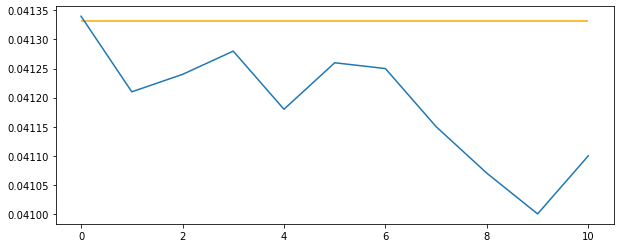

DEV-INFO: Valor interno del motor de decisiones [[0.49003273]]
Esperando el momento oportuno
DEV-INFO: Skip 0
Aquí tiene la gráfica de los últimos precios:


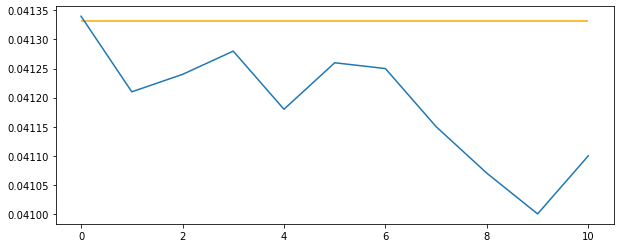

DEV-INFO: Valor interno del motor de decisiones [[0.49003273]]
Esperando el momento oportuno
DEV-INFO: Skip 0
Aquí tiene la gráfica de los últimos precios:


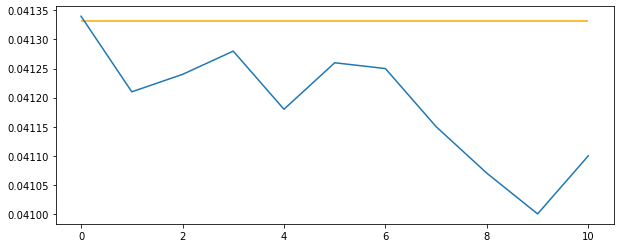

In [ ]:
API_SECRET_SANDBOX="xxxxxx"
API_KEY_SANDBOX="xxxxx"
API_PASS_SANDBOX="xxxx"

print("Inicializando librerias...")
import cbpro
auth_client = cbpro.AuthenticatedClient(API_KEY_SANDBOX, API_SECRET_SANDBOX, API_PASS_SANDBOX,
                                  api_url="https://api-public.sandbox.pro.coinbase.com")

import pandas as pd
from math import floor
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
from statistics import mean
from IPython.display import clear_output
rcParams['figure.figsize'] = 10, 4

import pickle

from time import sleep
import numpy as np
import tensorflow as tf
import keras

from keras.optimizers import SGD
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers.embeddings import Embedding
from keras import layers
from keras.layers.merge import concatenate
print("Librerias inicializadas")
print("Inicializando red neuronal...")
close_input = keras.Input(shape=(None,), name="close")
volume_input = keras.Input(shape=(None,), name="volume")

close_features = tf.expand_dims(close_input, axis=-1)
volume_features = tf.expand_dims(volume_input, axis=-1)


close_features = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(close_features)
close_features = layers.Dropout(0.5)(close_features)


volume_features = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(volume_features)
volume_features = layers.Dropout(0.5)(volume_features)


close_features = layers.LSTM(32)(close_features)
close_features = layers.Dropout(0.2)(close_features)


volume_features = layers.LSTM(32)(volume_features)
volume_features = layers.Dropout(0.2)(volume_features)

x = concatenate([close_features,volume_features])
#x=Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dense(128)(x)

output = layers.Dense(1,activation="sigmoid",name="futuro")(x)
#output = layers.Dense(1,activation="softmax",name="futuro")(x)
model = keras.Model(inputs=[close_input,volume_input],outputs=[output])

keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

model.compile(optimizer="adagrad", loss='binary_crossentropy',metrics=["accuracy"])
model.load_weights("pruebaGOOGLE100EPOCH.h5")
print("Red neuronal inicializada")
print("Inicializando funciones de compra/venta...")
import math
def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper
def getdata():
    dinero = auth_client.get_accounts()[1]["balance"]
    portfolio = auth_client.get_accounts()[2]["balance"]


    a= auth_client.get_product_historic_rates('ETH-BTC', granularity=300)
    ad=pd.DataFrame(a[0:30])
    ad.columns= ["time","low","high","open","close","volume"]
    ad["time"] = pd.to_datetime(ad["time"],unit='s')

    ad.set_index("time",inplace=True)
    dataclose=list(ad["close"])[::-1]
    datavol=list(ad["volume"])[::-1]
    return dinero,portfolio,dataclose,datavol

def brain(realdata,realdatavol,cutshort,cutlong):

    realdatarel=[]
    realdatarelvol=[]
    
    for i in range(1,len(realdata)):
        realdatarel.append(((realdata[i]/realdata[i-1])-1)*100)
    for i in range(10,len(realdatavol)):
        realdatarelvol.append(((realdatavol[i]/mean(realdatavol[i-5:i-1]))-1))
    
    realdatarel_array = np.array(realdatarel)
    ncols = realdatarel_array.shape[0]
    realdatarel_array = realdatarel_array.reshape(1, ncols, 1)
    
    realdatarelvol_array = np.array(realdatarelvol)
    ncols = realdatarelvol_array.shape[0]
    realdatarelvol_array = realdatarelvol_array.reshape(1, ncols, 1)
    #modelo red

    #predecir y aplicar el cut para el return
    realdata_Y = model.predict({"close":realdatarel_array,"volume":realdatarelvol_array})
    print("DEV-INFO: Valor interno del motor de decisiones "+str(realdata_Y))
    if realdata_Y < cutshort:
        return -1 #vender
    elif realdata_Y > cutlong:
        return 1 #comprar long
    else:
        return 0 #no está seguro
def comprar(acciones,precio):
    global dinero,portfolio,auth_client

    a = auth_client.buy(price=str(precio), #BTC
               size=str(acciones), #ETH
               order_type='limit',
               product_id='ETH-BTC')
    print("DEV-INFO: Respuesta de compra "+str(a))
    return True

def vender (acciones, precio):
    global dinero,portfolio,auth_client

    a = auth_client.sell(price=str(precio), #BTC
               size=str(acciones), #ETH
               order_type='limit',
               product_id='ETH-BTC')
    print("DEV-INFO: Respuesta de venta "+str(a))
    return True

def comprar_porcentaje(porcentaje,precio): #Gasta un porcentaje de tu dinero en acciones
    global dinero,portfolio

    acciones = str(truncate(((float(dinero)*float(porcentaje))/float(precio))*0.9,5))
    print("Comprados "+str(acciones)+" ETH")
    comprar(acciones,precio)
    return True

def vender_porcentaje(porcentaje,precio): #Vende un porcentaje de tu dinero total
    global dinero,portfolio
 
    acciones= str(truncate(float(portfolio*porcentaje)*0.9,2))
    print("Vendidos "+str(acciones)+" ETH")
    vender(acciones,precio)
    return True

class Historial:
    def __init__(self):
        self.dinerototal=[]
        self.dinero=[]
        self.precio=[]
        self.portfolio=[]
        self.decisiones=[]
    def savetimestep(self,dinero,portfolio,dinerototal,precio,decisiones):
        self.dinero.append(dinero)
        self.portfolio.append(portfolio)
        self.dinerototal.append(dinerototal)
        self.precio.append(precio)
        self.decisiones.append(decisiones)
    def savetofile(self,filename):
        with open(filename,"wb") as f:
            pickle.dump([self.dinero,self.portfolio,self.dinerototal,self.precio,self.decisiones],f)
    def loadfromfile(self,filename):
        with open(filename,"rb") as f:
            self.dinero,self.portfolio,self.dinerototal,self.precio,self.decisiones=pickle.load(f)
    def dibujar(self,arg="dinerototal"):
        global dinero_inicial
        if arg == "precio":
            print("Precio")

            plt.plot(self.precio)
            
            for i in range(len(self.decisiones)):
                if self.decisiones[i] == 1:
                    plt.scatter(i,self.precio[i],c="green",marker="^")
                if self.decisiones[i] == 0:
                    continue
                if self.decisiones[i] == -1:
                    plt.scatter(i,self.precio[i],c="red",marker="v")
            plt.show()
        if arg == "portfolio":
            print("Portfolio")

            plt.plot(self.portfolio)
            for i in range(len(self.decisiones)):
                if self.decisiones[i] == 1:
                    plt.scatter(i,self.portfolio[i],c="green",marker="^")
                if self.decisiones[i] == 0:
                    continue
                if self.decisiones[i] == -1:
                    plt.scatter(i,self.portfolio[i],c="red",marker="v")

        if arg == "dinerototal":
            #print("Dinero total")

            plt.plot(self.dinerototal, color="blue",label="Estrategia IA")
            
            hold = [i * (dinero_inicial/self.precio[0]) for i in self.precio]
            plt.plot(hold,color="magenta",label="Estrategia hold")
            
            for i in range(len(self.decisiones)):
                if self.decisiones[i] == 1:
                    plt.scatter(i,self.dinerototal[i],c="green",marker="^")
                if self.decisiones[i] == 0:
                    continue
                if self.decisiones[i] == -1:
                    plt.scatter(i,self.dinerototal[i],c="red",marker="v")
            plt.show()
print("Funciones de compra/venta inicializadas")
print("--------------------------------")
print("Neko AI inicializada: Bienvenido")
print("--------------------------------")
#historial = Historial()

decisiones=0
action=False
timesteps=10000
for timestep in range(0,timesteps):
    dinero,portfolio,dataclose,datavol = getdata()
    precio=dataclose[-1]
    ultimosprecios=dataclose[-12:-1]
    volumen=datavol[-1]
    ultimosvolumenes=datavol[-12:-1]
    
    #algoritmo compra/venta
    #if timestep <201:
    #   comprar_porcentaje(0.9,precio)
    if action==True:
        if decisiones==1 and float(precio)/ultimosprecios[9]>1:
            vender_porcentaje(1,precio)
            print("Cambiando 100% a BTC")
            
            decisiones=0
            action=False
            continue
        elif decisiones==-1 and float(precio)/ultimosprecios[9]<1:
            comprar_porcentaje(1,precio)
            print("Cambiando 100% a ETH")
            
            decisiones=0
            action=False
            continue
        else:
            print("Esperando el momento oportuno")
            print("DEV-INFO: Queue "+str(decisiones))
            print("Aquí tiene la gráfica de los últimos precios:")
            plt.plot(ultimosprecios)
            plt.hlines(mean(dataclose[-22:-1]),0,10,colors="orange")
            plt.show()
            sleep(300)
            continue
 #0.45,0.51,0.2,1
    decisiones=brain(ultimosprecios,ultimosvolumenes,0.45,0.51)
    if decisiones ==1 and float(precio)/mean(dataclose[-22:-1])<1:
        comprar_porcentaje(1,precio)
        print("Cambiando 100% a ETH")
        action=True
    elif decisiones==-1 and float(precio)/mean(dataclose[-22:-1])>1:
        vender_porcentaje(1,precio)
        print("Cambiando 100% a BTC")
        action=True
    else:
        print("Esperando el momento oportuno")
        print("DEV-INFO: Skip "+str(decisiones))
    print("Aquí tiene la gráfica de los últimos precios:")
    plt.plot(ultimosprecios)
    plt.hlines(mean(dataclose[-22:-1]),0,10,colors="orange")
    plt.show()
    sleep(300)
    #fin algoritmo compra/venta

In [96]:
ultimosprecios[7:10]

[103.54694532399999, 103.537195141, 103.537195141]

In [66]:
print("Beneficio: "+str("{:.2f}".format(((dinerototal/100000)-1)*100))+"%")

Beneficio: 10.87%


In [78]:
print("Dinero total: "+str("{:.2f}".format(round(int(dinerototal),2))))

Dinero total: 100366.00


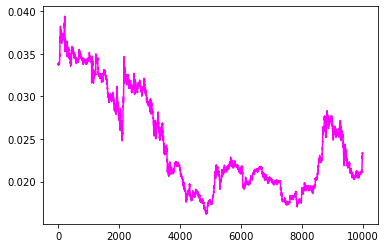

In [27]:
hold = [i * (dinero_inicial/historial.precio[0]) for i in historial.precio]
%matplotlib inline
plt.plot(dataclose[200:10200],color="magenta",label="Estrategia hold")
plt.show()

In [24]:
dinero_inicial/historial.precio[0]

2953337.2711163615

In [1]:
import pickle
%matplotlib widget
import matplotlib.pyplot as plt


class Historial:
    def __init__(self):
        self.dinerototal=[]
        self.dinero=[]
        self.precio=[]
        self.portfolio=[]
        self.decisiones=[]
    def savetimestep(self,dinero,portfolio,dinerototal,precio,decisiones):
        self.dinero.append(dinero)
        self.portfolio.append(portfolio)
        self.dinerototal.append(dinerototal)
        self.precio.append(precio)
        self.decisiones.append(decisiones)
    def savetofile(self,filename):
        with open(filename,"wb") as f:
            pickle.dump([self.dinero,self.portfolio,self.dinerototal,self.precio,self.decisiones],f)
    def loadfromfile(self,filename):
        with open(filename,"rb") as f:
            self.dinero,self.portfolio,self.dinerototal,self.precio,self.decisiones=pickle.load(f)
    def dibujar(self,arg="dinerototal"):
        global dinero_inicial
        if arg == "precio":
            print("Precio")

            plt.plot(self.precio)
            
            for i in range(len(self.decisiones)):
                if self.decisiones[i] == 1:
                    plt.scatter(i,self.precio[i],c="green",marker="^")
                if self.decisiones[i] == 0:
                    continue
                if self.decisiones[i] == -1:
                    plt.scatter(i,self.precio[i],c="red",marker="v")
            plt.show()
        if arg == "portfolio":
            print("Portfolio")

            plt.plot(self.portfolio)
            for i in range(len(self.decisiones)):
                if self.decisiones[i] == 1:
                    plt.scatter(i,self.portfolio[i],c="green",marker="^")
                if self.decisiones[i] == 0:
                    continue
                if self.decisiones[i] == -1:
                    plt.scatter(i,self.portfolio[i],c="red",marker="v")

        if arg == "dinerototal":
            #print("Dinero total")

            plt.plot(self.dinerototal, color="blue",label="Estrategia IA")
            
            hold = [i * (float(self.dinerototal[0])/self.precio[0]) for i in self.precio]
            plt.plot(hold,color="magenta",label="Estrategia hold")
            
            for i in range(len(self.decisiones)):
                if self.decisiones[i] == 1:
                    plt.scatter(i,self.dinerototal[i],c="green",marker="^")
                if self.decisiones[i] == 0:
                    continue
                if self.decisiones[i] == -1:
                    plt.scatter(i,self.dinerototal[i],c="red",marker="v")
            plt.show()


In [2]:
historial=Historial()
historial.loadfromfile("historial.pkl")
historial.dibujar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [5]:
historial.precio[60:70]

[0.03676,
 0.03682,
 0.03675,
 0.03678,
 0.03713,
 0.03753,
 0.03782,
 0.03813,
 0.03827,
 0.03842]

In [8]:
auth_client.get_orders()

NameError: name 'auth_client' is not defined